<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

# Example: Advanced Model for Portfolio Climate Risk Assessment 

This [Jupyter notebook](https://jupyter.org) contains a minimal working example of a climate-risk assessment at portfolio level.

Author: Alfonso Caiazzo, [HEDERA Sustainable Solutions](https://hedera.online)
License: This file is open-source, released under a MIT license. Usage, reproduction, and modification are allowed. Please cite the original source as

*HEDERA: Modeling Climate Risk Assessment at Portfolio Level for Microfinance Institutions, Jupyter Notebook, 2024*

when using the sources.

## Introduction

#### Scope

The scope of the assessment is to quantify, using available data, to which extend the portfolio of the institution is affected by different climate hazards. In detail, the goal of the model is to assign to each loan in the portfolio a **vulnerability index** that can be related to the probability of default of the associated client activity. 

#### Data

The analysis is based on a sample database file which has been released with the notebook. When adapting the model to individual situations, types and names of the column shall be accordingly modified.

#### Approach

- (1) First, the loan database is segmented according to geographical distribution (branches/regions) and to the sector or sub-sectors of activities. 
- (1+) Other relevant variables are considered and analyzed (e.g., group sizes, gender, loan cycle)
- (2) The **exposure to different climate hazards** of each loan is assessed, according to the location. In this example, the exposure to different hazards is taken at the regional level (i.e., the exposure of each loan depends on the branch where this is disboursed). 
- (3) For each considered climate hazard, a **base** vulnerability index for each relevant activity sector, identified in step (1), is assigned, depending on the potential negative impact that the hazard could have on this type of activity (considering assets, market, clients, and logistics).
- (4) Define the risk model taking into account, for each hazard, the base vulnerability index, and additional variables of the loan definition
- (5) compute the risk index for each loan is computed as 

```risk index (of a physical risk) = exposure (geographical) * vulnerability index```

##### Exposure (to a physical risk)

This depends on the probability that an adverse event or a chronic hazard happens, with a defined intensity, in a defined period of time. The most important variables to assess the exposure to a physical risk are therefore

- The **indicator** used to monitor the intensity
- The **occurrence** (or return period) of the event

##### Vulnerability (to a physical risk)

The vulnerability depends on the relevance that a certain physical risk can have on the incoming generating activities. Vulnerability is assessed in two parts:

- (basic) **Sector vulnerability** ranking and estimating different possible *impacts*, for each relevant *sector of activity*.
- (advanced) **Loan-specific variation**: adjustement of the sector vulnerability including other variables such as loan size, duration, group size, etc.

#### Observations

- The exposure level could be improved considering a more precise location of the activities and, where available, integrating data on previous climate events and trends

</div>


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">
    
## Step 1: Preparation & Requirements

First, the required packages should be imported: pandas, numpy, seaborn, matplotlib, plotly, IPython

The [Josefin Sans](https://fonts.google.com/specimen/Josefin+Sans) font is used. In order to run properly the notebook, the font should be downloaded and moved into `fonts/JosefinSans-Regular.ttf`.
When running the notebook locally, these packages should be installed. If not, you can install those using `pip`
    
If required, the charts can be created as png. These will be saved in the `output/` directory.
 
</div>

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">
    
The following lines specify and configure the libraries used for the analysis and for generating charts.
   
</div>

In [138]:
import pandas as pd
import numpy as np

# libraries and configurations for plotting
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fontpath = 'fonts/JosefinSans-Regular.ttf'
fm.fontManager.addfont(fontpath)
prop = fm.FontProperties(fname=fontpath)
matplotlib.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = "regular"

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display, HTML, Markdown
from plotly.offline import init_notebook_mode, plot

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">
First, we read the example file and display few lines and the list of available column names (variables)
</div>

In [139]:
filename = "data/portfolio_example_data.xlsx"
portfolio = pd.read_excel(filename,sheet_name='example_data')
# show 3 lines
portfolio.head(3)


,Branch,Area,Type,Number of Dependent Children,District,Number of clients,Loan Cycle,Duration,Loan Amount,Average PPI Score,Loan: Number of Days Past Due,Business Sector,Business Sub-Sector
0,8,rural,group,27.0,Jinja,5,2,15,1200000,0,0,"Agriculture, Forestry, Fishery",Crop Production (Cereals)
1,8,rural,group,23.0,Jinja,5,3,9,825000,0,25,"Agriculture, Forestry, Fishery",Crop Production (Cereals)
2,8,rural,group,39.0,Jinja,6,3,9,1350000,0,26,"Agriculture, Forestry, Fishery",Crop Production (Cereals)


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">
We select now the columns that we want to consider for the model. This is done creating a list of variables, and selecting those from the original dataframe.
</div>

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

### Portfolio breakdown

First, we look at the loan amount per region/district and per business sector (and sub-sector).

</div>

In [140]:
# Aggregate loan amounts by region
region_loan_totals = portfolio.groupby("District")["Loan Amount"].sum().reset_index()

fig_region = px.bar(region_loan_totals, 
                    x="District", y="Loan Amount", 
                    title="(Example) Loan Amounts by District",
                    labels={
                        "District": "District", 
                        "Loan Amount": "Total Loan Amount ($)"
                    },
                    color_discrete_sequence=["#636EFA"]
                   )  # Set bar color

# Calculate percentage of each region's loan amount
region_loan_totals['percentage'] = region_loan_totals['Loan Amount'] / region_loan_totals['Loan Amount'].sum()
# Format percentage as string with one decimal place
region_loan_totals['percentage_str'] = region_loan_totals['percentage'].apply(lambda x: f'{x:.1%}')
# Add percentage annotations to each bar
fig_region.update_traces(text=region_loan_totals['percentage_str'], textposition='outside',
                         marker_color='rgb(158,202,225)', textfont_size=12)
fig_region.update_layout(template='simple_white', font_family='Josefin Sans')

fig_region.show()

In [141]:
# Aggregate loan amounts by sector
sector_loan_totals = portfolio.groupby("Business Sub-Sector")["Loan Amount"].sum().reset_index()

fig_sector = px.bar(sector_loan_totals, 
                    y="Business Sub-Sector", 
                    x="Loan Amount", 
                    title="Loan Amounts by Sector",orientation="h",
                    labels={
                        "Business Sub-Sector": "Sector", 
                        "Loan Amount": "Total Loan Amount ($)"},
                    color_discrete_sequence=["#636EFA"]
                   )

# Calculate percentage of each region's loan amount
sector_loan_totals['percentage'] = sector_loan_totals['Loan Amount'] / sector_loan_totals['Loan Amount'].sum()

# Format percentage as string with one decimal place
sector_loan_totals['percentage_str'] = sector_loan_totals['percentage'].apply(lambda x: f'{x:.1%}')

# Add percentage annotations to each bar
fig_sector.update_traces(text=sector_loan_totals['percentage_str'], textposition='outside',
                         marker_color='rgb(158,202,225)', textfont_size=12)
fig_sector.update_layout(template='simple_white', font_family='Josefin Sans',height=700)

fig_sector.show()


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

Combining these two results,  we create a heatmap shows the percentage of loan in each region/sector.
</div>

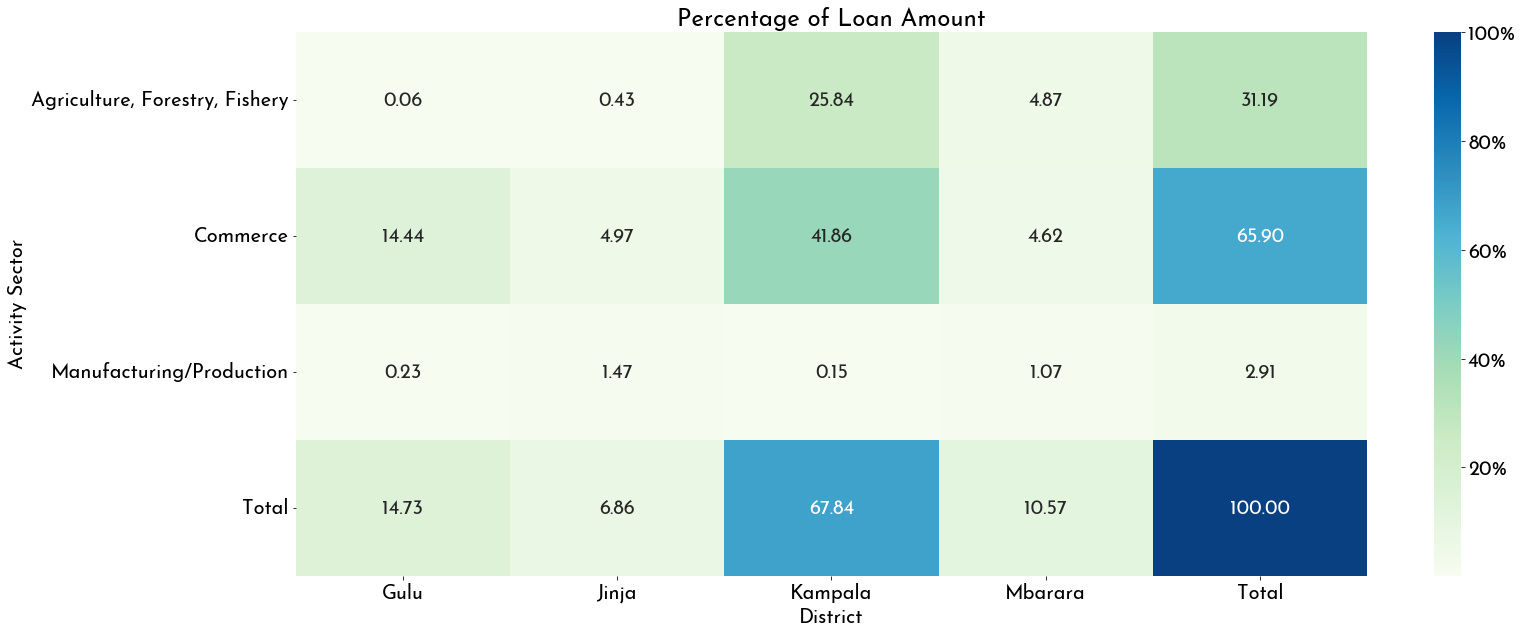

In [142]:
# Create a pivot table
pivot_table = portfolio.pivot_table(
    values='Loan Amount', 
    index='Business Sector',
    columns='District', 
    aggfunc=np.sum, fill_value=0)

# Calculate totals for each region and sector
region_totals = pivot_table.sum(axis=0)
sector_totals = pivot_table.sum(axis=1)

# Add totals to the pivot table
pivot_table.loc['Total'] = region_totals
pivot_table['Total'] = sector_totals
pivot_table.loc['Total', 'Total'] = pivot_table['Total'].sum()

# Calculate the percentage
total_loan_amount = pivot_table.loc['Total', 'Total']
percentage_pivot_table = pivot_table / total_loan_amount * 100

# Plot the heatmap
plt.figure(figsize=(24, 10))
sns.heatmap(percentage_pivot_table, annot=True, fmt=".2f", cmap="GnBu", cbar_kws={'format': '%.0f%%'})
plt.title('Percentage of Loan Amount')
plt.xlabel('District')
plt.ylabel('Activity Sector')
plt.show()

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

We can do the same analysis considering sub-sectors. 

</div>

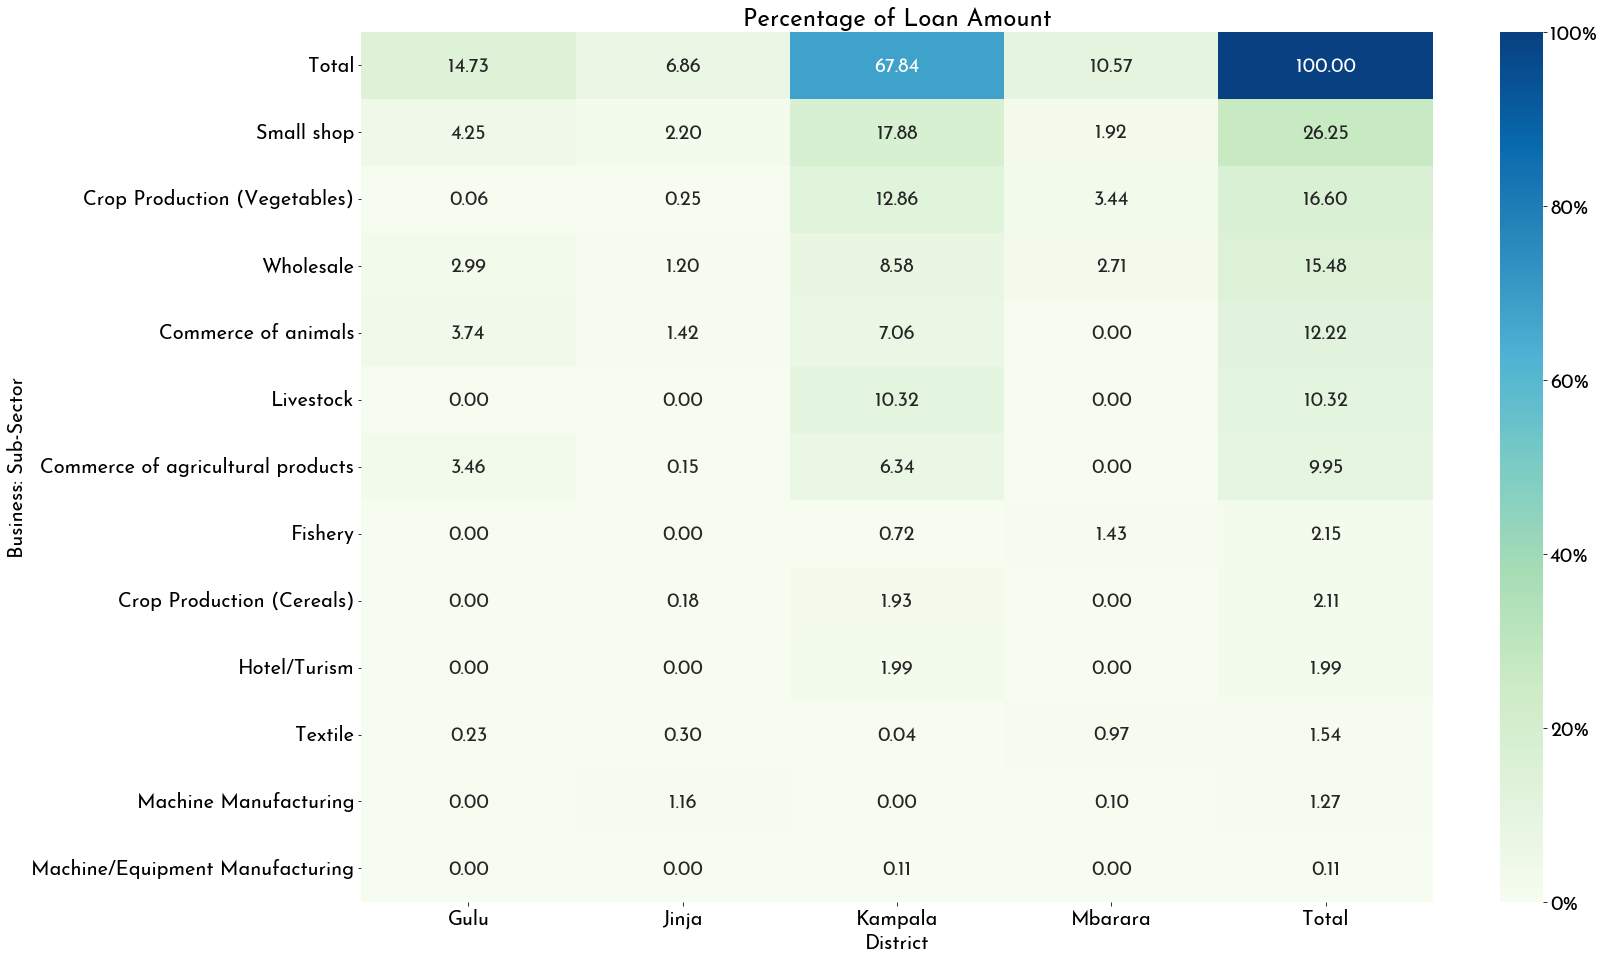

In [143]:
# Calculate the total count of each 'Business Sub-Sector'
sub_sector_counts = portfolio['Business Sub-Sector'].value_counts()

# For simplicity, we rename the less popular sub-sectors as "Other". (uncomment the following lines)
# # Determine the threshold for 5% of the total count
# total_count = len(portfolio)
# threshold = total_count * 0.035
# # Replace 'Business Sub-Sector' values with 'Other' + 'Business Sector' if their count is below the threshold
# portfolio['Business Sub-Sector'] = portfolio.apply(
#     lambda row: f"Other - {row['Business Sector']}" if sub_sector_counts[row['Business Sub-Sector']] < threshold else row['Business Sub-Sector'], axis=1)


# Create a pivot table
pivot_table = portfolio.pivot_table(
    values='Loan Amount', 
    index='Business Sub-Sector', 
    columns='District', aggfunc=np.sum, fill_value=0)

# Calculate totals for each region and sector
region_totals = pivot_table.sum(axis=0)
sector_totals = pivot_table.sum(axis=1)

# Add totals to the pivot table
pivot_table.loc['Total'] = region_totals
pivot_table['Total'] = sector_totals
pivot_table.loc['Total', 'Total'] = pivot_table['Total'].sum()

# Calculate the percentage
total_loan_amount = pivot_table.loc['Total', 'Total']
percentage_pivot_table = pivot_table / total_loan_amount * 100

# Sort rows based on total percentages
sorted_rows = percentage_pivot_table['Total'].sort_values(ascending=False).index
sorted_percentage_pivot_table = percentage_pivot_table.loc[sorted_rows]

# Plot the heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(sorted_percentage_pivot_table, annot=True, fmt=".2f", cmap="GnBu", cbar_kws={'format': '%.0f%%'})
plt.title('Percentage of Loan Amount')
plt.xlabel('District')
plt.ylabel('Business: Sub-Sector')

# Save the figure to a file
plt.savefig('./loan_amount_heatmap.png',bbox_inches='tight')

plt.show()


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

## Step 2. Exposure to physical risks

Next, we have to specify the exposure to different climate risks of each region. We consider 4 levels:

<div>



<div style="background-color: #cd6155; color: white; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

- Low/Very low (0)
- Moderate (0.33)
- High (0.66)
- Very High (1)

</div>

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

### Background Information on Exposure and Risks

1. **Extreme Heat**: The tropical climate in Uganda can lead to high temperatures, particularly affecting regions like Gulu and Mbarara, where temperatures can be intense during the dry season.
2. **Water Scarcity**: Regions like Gulu and parts of Mbarara can face water scarcity during prolonged dry periods, affecting both agricultural and daily water needs.
3. **Wildfire**: Wildfires, though not very common, can occur in the dry grasslands of Gulu and Mbarara due to dry spells and drought conditions.
4. **Flood**: The proximity to water bodies like the Nile in Jinja and wetlands in Kampala increases the risk of flooding, especially during the rainy season.
5. **Heavy Rain**: Regions like Jinja and Kampala experience heavy rainfall, which can lead to localized flooding and soil erosion, especially in urban areas with poor drainage.
6. **Sea Level Rise**: Uganda, being landlocked, does not face risks from sea level rise.

### Regional Assessment

The exposure is defined in a dictionary, specifying the level for each climate hazard in each region.

1. **Kampala**: As the capital city, Kampala faces risks primarily related to heavy rains and flooding, especially in low-lying areas with poor drainage systems.
2. **Mbarara**: Known for its agricultural activities, this region faces significant risks of drought and extreme heat, particularly affecting rural communities and livestock farming.
3. **Gulu**: Located in northern Uganda, Gulu is exposed to risks of extreme heat, water scarcity, and occasional wildfires, especially during prolonged dry seasons.
4. **Jinja**: With its proximity to Lake Victoria and the Nile River, Jinja faces significant risks of flooding and heavy rains, impacting both urban infrastructure and agricultural activities in the surrounding areas. 


The results of the assessment are stored in a variable `physical_risk_exposure`. In particular, the value of the exposure level to a particular hazard and for a region are given by:
    
```
physical_risk_exposure[HAZARD NAME][REGION NAME]
```
</div>

In [144]:
physical_risk_exposure = {
    'Extreme Heat': {
        'Kampala': 0.33,
        'Mbarara': 1, 
        'Gulu': 1, 
        'Jinja': 0.33
    },
    'Water Scarcity': {
        'Kampala': 0.33,
        'Mbarara': 0.66, 
        'Gulu': 1, 
        'Jinja': 0.33
    },
    'Wildfire': {
        'Kampala': 0,
        'Mbarara': 0.66, 
        'Gulu': 1, 
        'Jinja': 0.33
    },
    'Flood': {
        'Kampala': 1,
        'Mbarara': 0.33, 
        'Gulu': 0.66, 
        'Jinja': 1
    },
    'Heavy Rain': {
        'Kampala': 1,
        'Mbarara': 0.66, 
        'Gulu': 0.66, 
        'Jinja': 1
    },
}


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

## Step 3. Vulnerability of Business Sectors

For each considered activity sector, a vulnerability level (and score) shall be defined. For this, we consider the possible impact of each physical hazard.

    
</div>

<div style="background-color: #cd6155; color: white; padding: 10px; font-family: 'Avenir'; font-size: 12pt">



1. **Livestock (Commerce of animals & Livestock):** High vulnerability to extreme heat and water scarcity due to the need for water, fodder, and suitable grazing conditions. Moderate sensitivity to wildfires and floods as these can impact grazing areas and animal health.

2. **Crop Production (Vegetables & Cereals):** High vulnerability to extreme heat, water scarcity, and heavy rains. These climate factors directly impact crop yields, with extreme heat stressing crops and water scarcity affecting irrigation. Heavy rains can lead to soil erosion and crop damage.

3. **Retail Trade (Small shops & Commerce):** Moderate vulnerability to floods and heavy rains as these can disrupt business operations, damage stock, and reduce customer traffic. Small shops, in particular, are vulnerable due to their localized nature and often limited capacity to handle climate impacts.

4. **Commerce of Agricultural Products:** High vulnerability to water scarcity and floods. The availability and quality of agricultural products are directly affected by climate conditions, leading to supply chain disruptions and price volatility. Flooding can also damage stored goods.

5. **Textile and Machine Manufacturing:** Moderate vulnerability to floods and heavy rains, which can damage production facilities, machinery, and raw materials. Textile businesses are also somewhat sensitive to water scarcity, affecting processes like dyeing and finishing.

6. **Fishery:** High vulnerability to extreme heat and heavy rains. Extreme temperatures can affect fish populations, while heavy rains may cause water quality issues and disrupt fishing activities.

7. **Hotel/Tourism:** Moderate to high vulnerability to floods and heavy rains, which can disrupt operations, damage infrastructure, and deter tourists. Coastal and riverside tourism businesses are particularly at risk from flooding.

8. **Machine/Equipment Manufacturing:** Moderate vulnerability to floods and heavy rains. These can damage machinery, disrupt supply chains, and affect production timelines.

    
</div>

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

Similarly as for the exposure, the results of the assessment are stored in a variable `physical_risk_vulnerability`. In particular, the value of the exposure level to a particular hazard and for a region are given by:
    
```
physical_risk_vulnerability[HAZARD NAME][SECTOR NAME]
```

    
The values of vulnerability shall be defined depending on the local context from 0 (very low vulnerability) to 1 (very high vulnerability).
    
</div>

In [145]:
physical_risk_vulnerability = {
    'Extreme Heat': {
        'Small shop': 0.5,
        'Crop Production (Vegetables)': 0.9,
        'Wholesale': 0.5,
        'Commerce of animals': 0.8,
        'Commerce of agricultural products': 0.7,
        'Livestock': 0.8,
        'Crop Production (Cereals)': 0.9,
        'Textile': 0.4,
        'Machine Manufacturing': 0.3,
        'Fishery': 0.6,
        'Hotel/Turism': 0.5,
        'Machine/Equipment Manufacturing': 0.3
    },
    'Water Scarcity': {
        'Small shop': 0.6,
        'Crop Production (Vegetables)': 0.9,
        'Wholesale': 0.6,
        'Commerce of animals': 0.8,
        'Commerce of agricultural products': 0.7,
        'Livestock': 0.8,
        'Crop Production (Cereals)': 0.9,
        'Textile': 0.3,
        'Machine Manufacturing': 0.2,
        'Fishery': 0.5,
        'Hotel/Turism': 0.4,
        'Machine/Equipment Manufacturing': 0.2
    },
    'Wildfire': {
        'Small shop': 0.4,
        'Crop Production (Vegetables)': 0.8,
        'Wholesale': 0.4,
        'Commerce of animals': 0.7,
        'Commerce of agricultural products': 0.5,
        'Livestock': 0.7,
        'Crop Production (Cereals)': 0.8,
        'Textile': 0.3,
        'Machine Manufacturing': 0.3,
        'Fishery': 0.6,
        'Hotel/Turism': 0.5,
        'Machine/Equipment Manufacturing': 0.3
    },
    'Flood': {
        'Small shop': 0.8,
        'Crop Production (Vegetables)': 0.8,
        'Wholesale': 0.8,
        'Commerce of animals': 0.7,
        'Commerce of agricultural products': 0.7,
        'Livestock': 0.5,
        'Crop Production (Cereals)': 0.8,
        'Textile': 0.5,
        'Machine Manufacturing': 0.5,
        'Fishery': 0.7,
        'Hotel/Turism': 0.8,
        'Machine/Equipment Manufacturing': 0.5
    },
    'Heavy Rain': {
        'Small shop': 0.7,
        'Crop Production (Vegetables)': 0.8,
        'Wholesale': 0.7,
        'Commerce of animals': 0.5,
        'Commerce of agricultural products': 0.7,
        'Livestock': 0.5,
        'Crop Production (Cereals)': 0.8,
        'Textile': 0.4,
        'Machine Manufacturing': 0.4,
        'Fishery': 0.8,
        'Hotel/Turism': 0.8,
        'Machine/Equipment Manufacturing': 0.4
    }
}


<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

We can combine exposure weight and sensitivity weights to visualize a matrix of physical risks per region and sector.
    
</div>

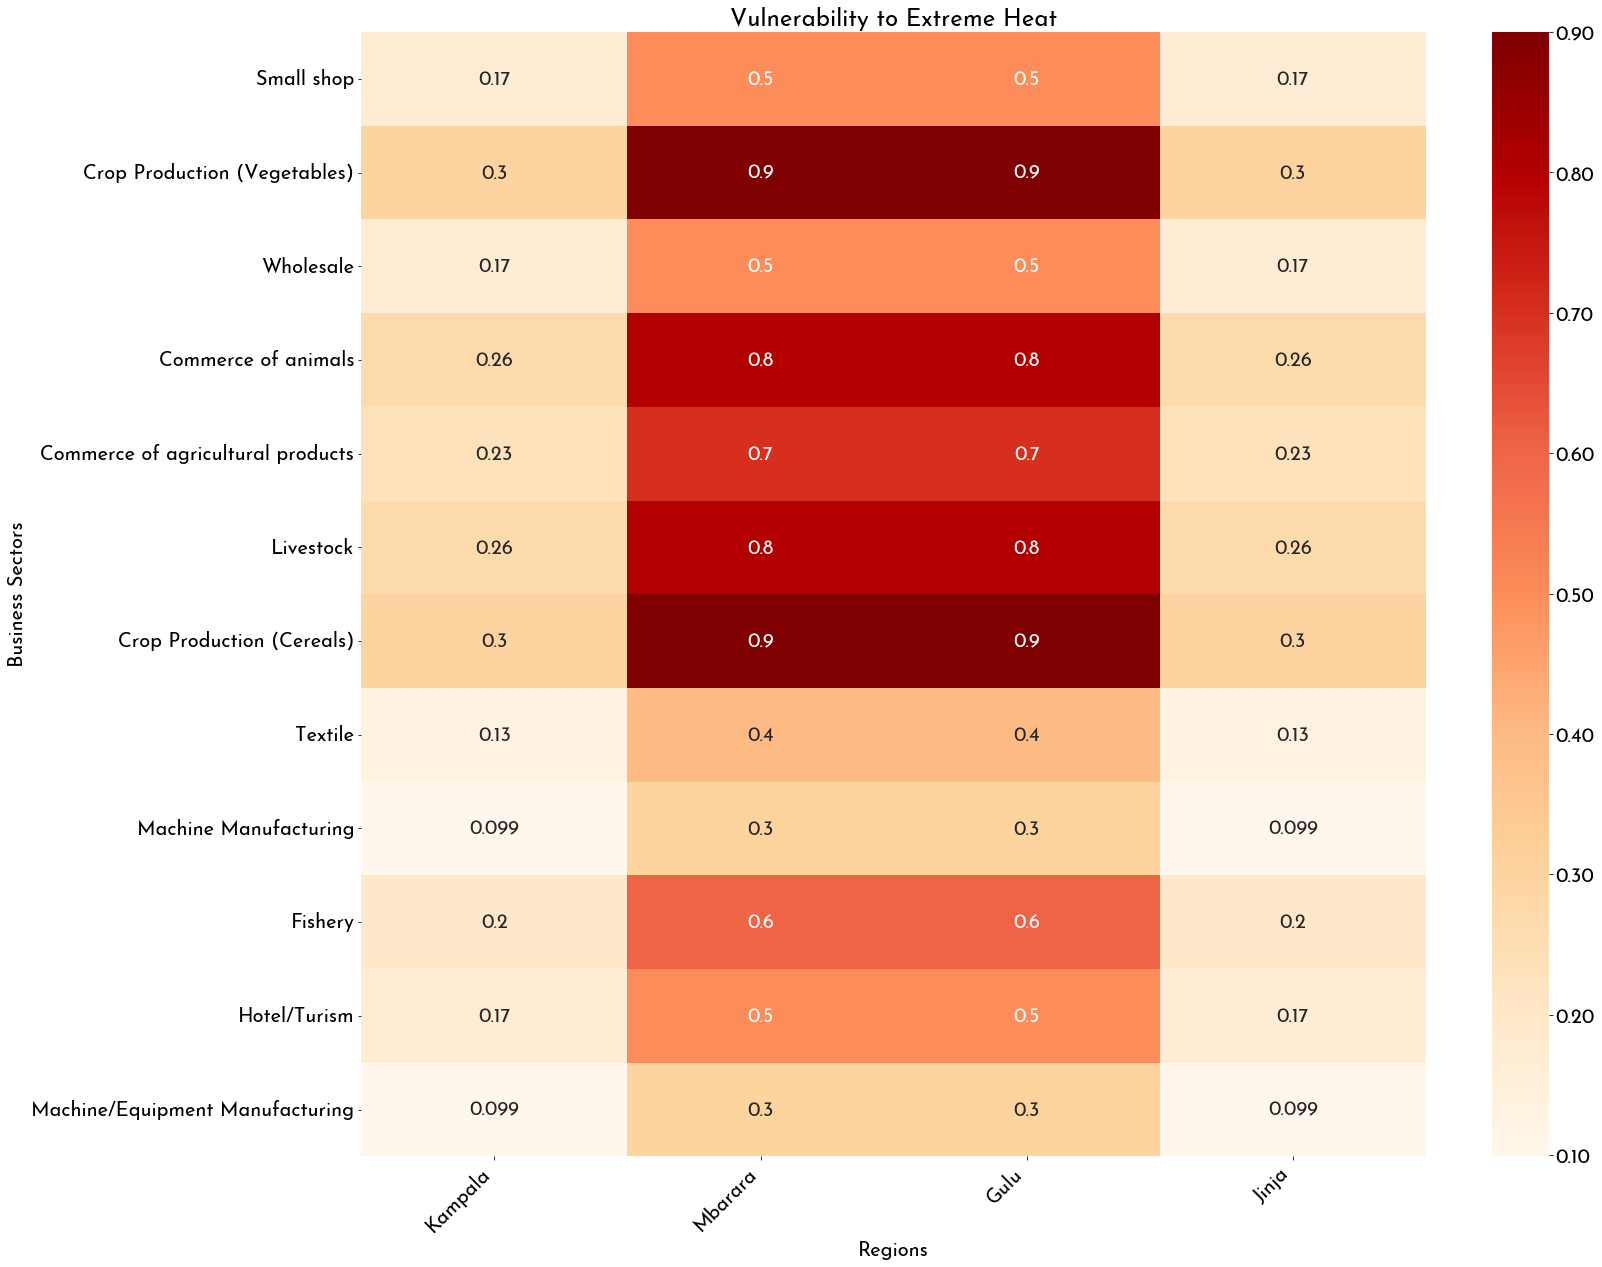

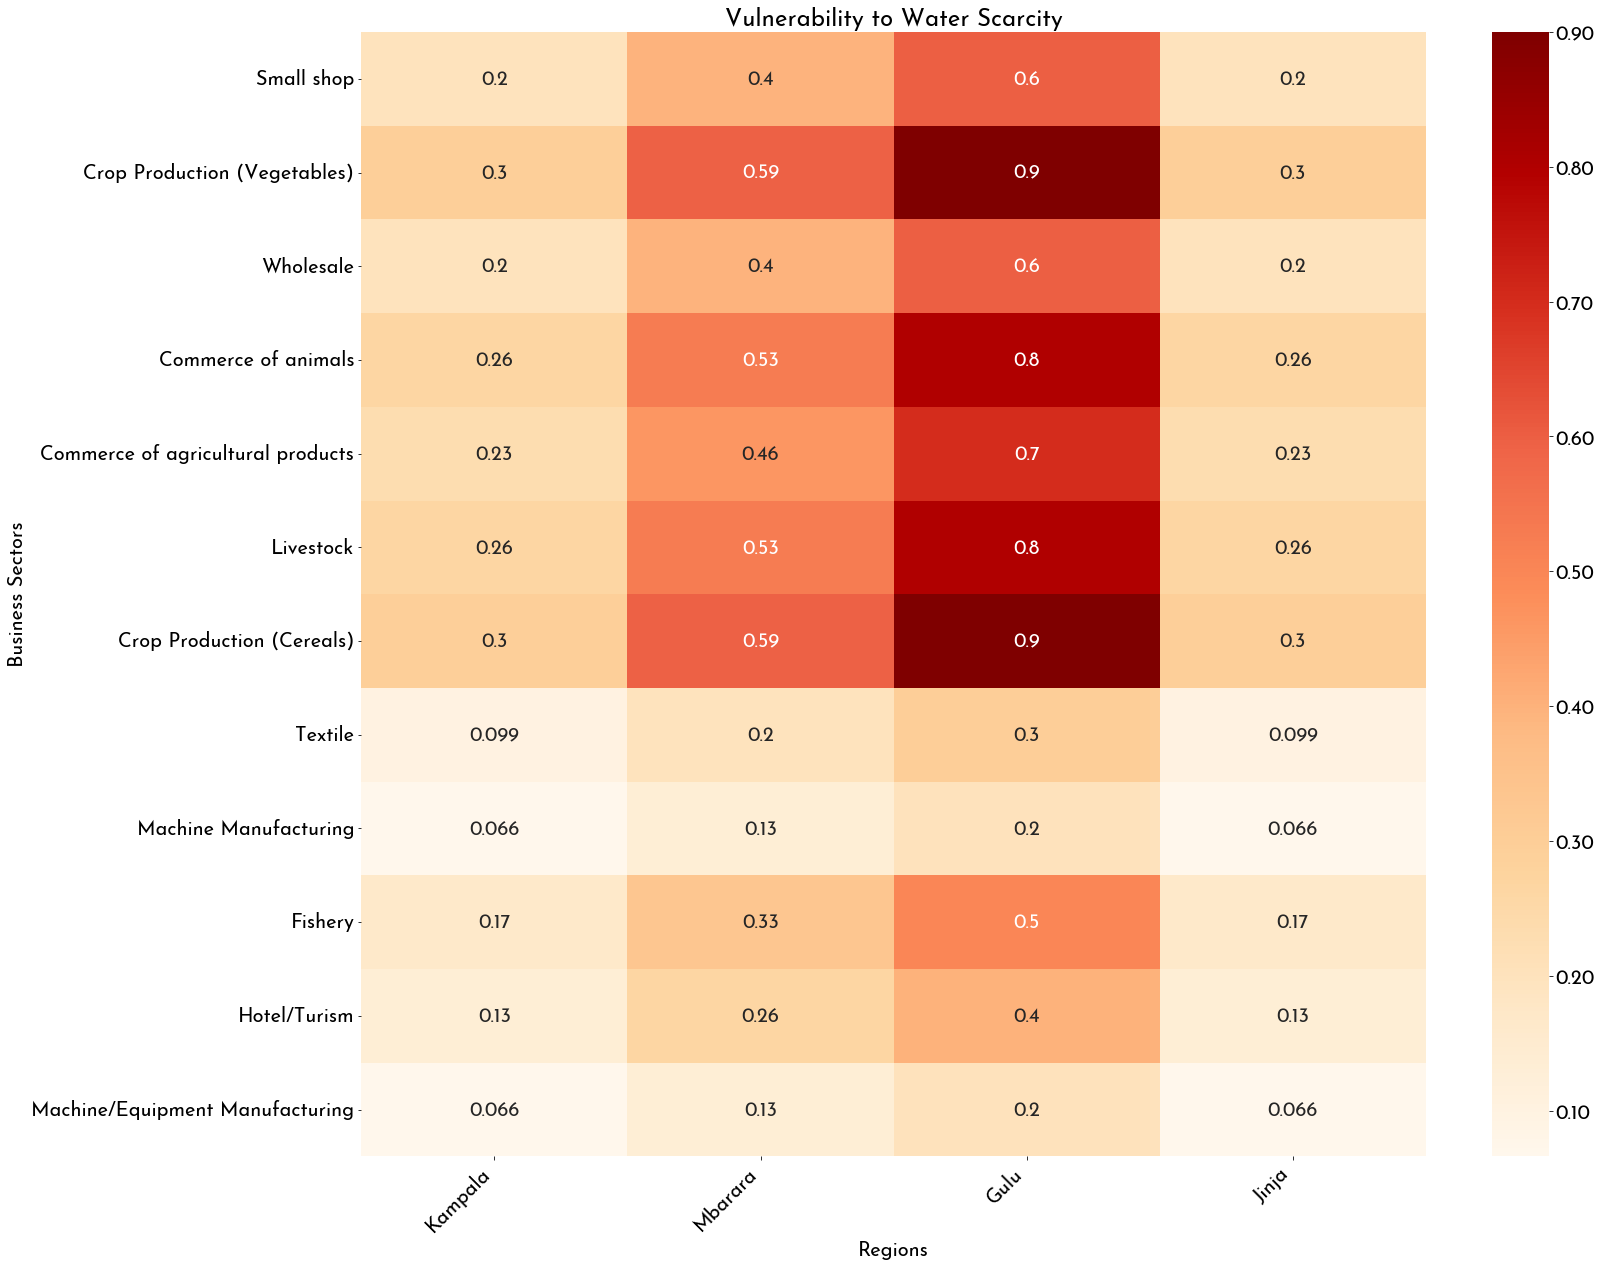

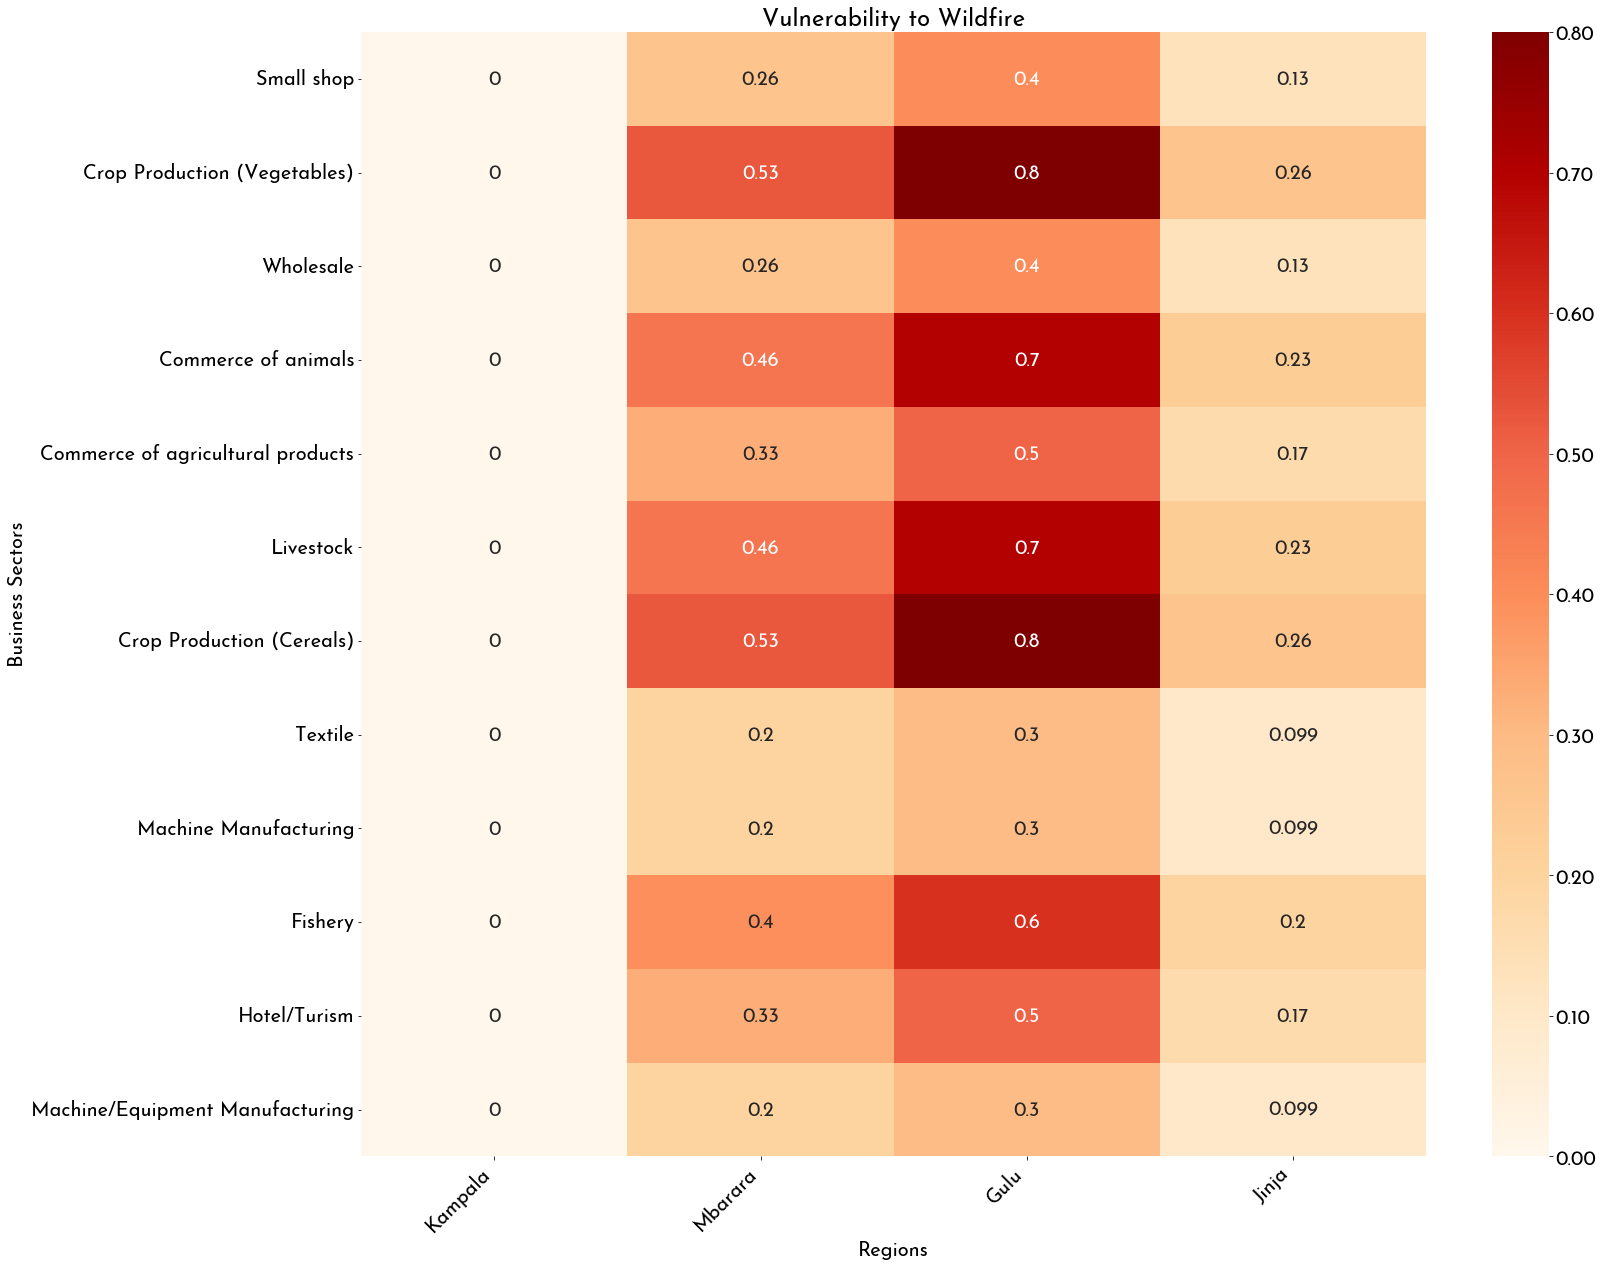

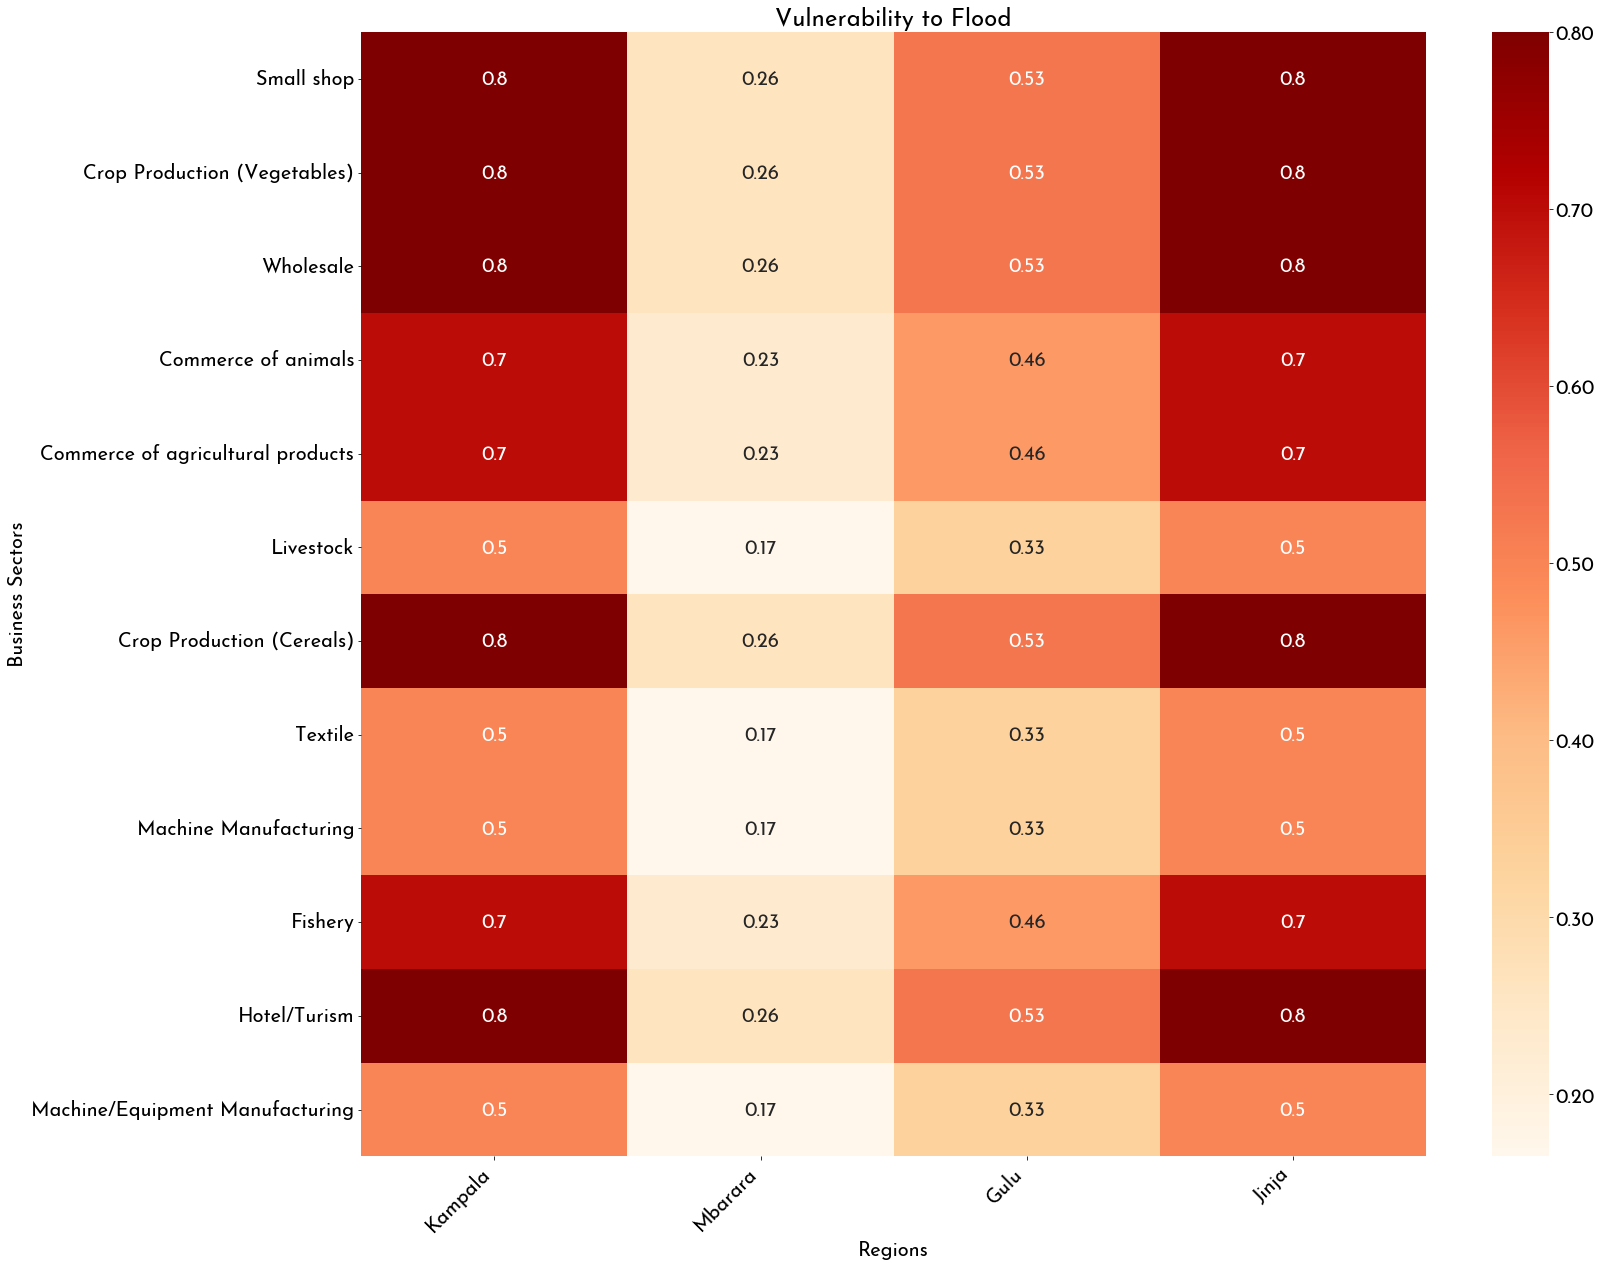

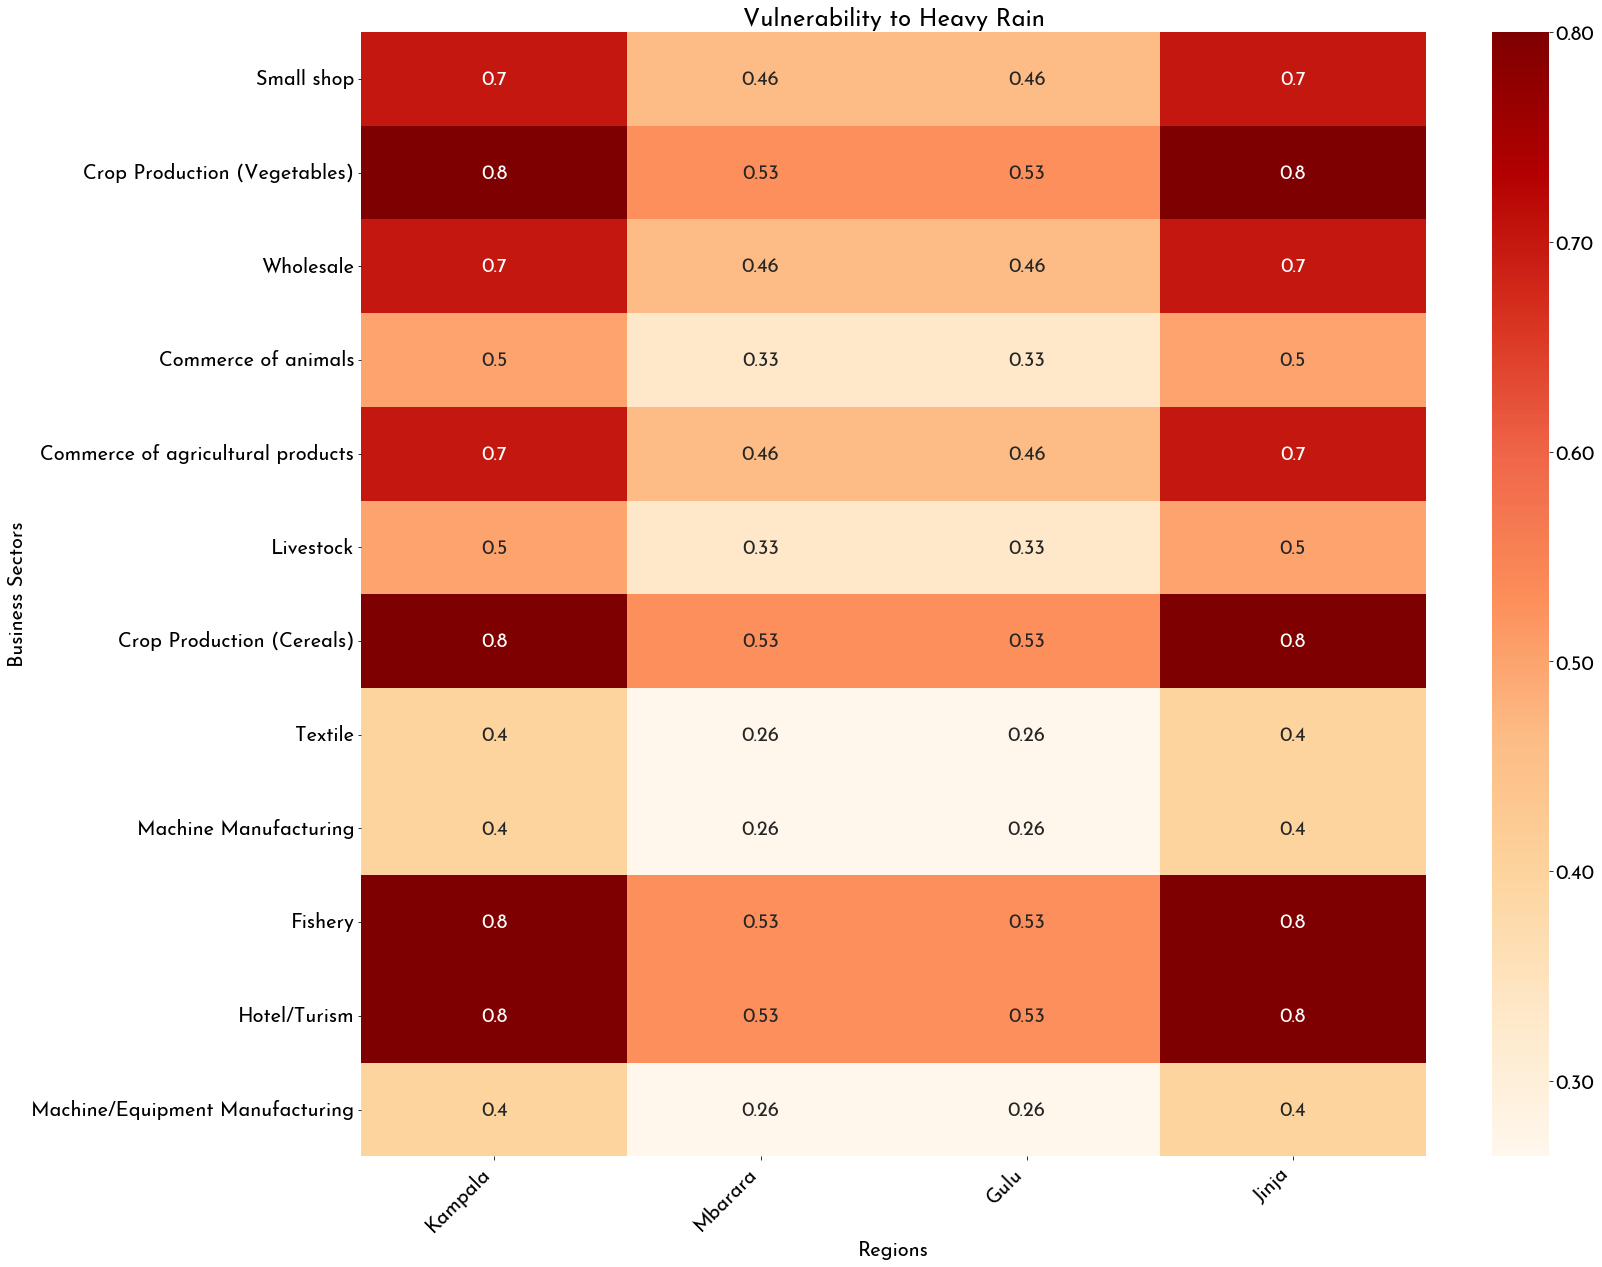

In [147]:
portfolio_distribution_table = pivot_table
total_loan_amount = portfolio_distribution_table.loc['Total', 'Total']

# Create heatmaps for each climate risk
for risk in physical_risk_exposure.keys():
    exposure = physical_risk_exposure[risk]
    sens = physical_risk_vulnerability[risk]
    
    
    # Create a DataFrame to store the results
    regions = list(exposure.keys())
    sectors = list(sens.keys())
    result = pd.DataFrame(index=sectors, columns=regions)
    weighted_risk = pd.DataFrame(index=sectors, columns=regions)
    
    
    for region in regions:
        for sector in sectors:
            result.at[sector,region] = exposure[region] * sens[sector]
            weighted_risk.at[sector,region] = (exposure[region] * sens[sector] * 
                                               portfolio_distribution_table[region][sector]/ total_loan_amount * 100)
            
    # Plot the vulnerability overview heatmap
    plt.figure(figsize=(24, 18))
    sns.heatmap(result.astype(float), annot=True, cmap="OrRd", cbar_kws={'format': '%.2f'})
    plt.title(f'Vulnerability to {risk}')
    plt.ylabel('Business Sectors')
    plt.xlabel('Regions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the figure to a file
    #filename = f'vulnerability_to_{risk.replace(" ", "_").lower()}.png'
    #plt.savefig(filename)
    #plt.show()
    

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">
    
## Step 4. Advanced Vulnerability & Exposure Model

Next, we take into account additional variables to adjust the vulnerability scores.

The following function

```
def vulnerability_estimate(risk,x,advanced=False):
```

takes three arguments:
- `climate_hazard`: the physical climate hazard
- `loan`: a row of the loan database
- (optional) `advanced`: set to `True` to consider the advanced model

### Sector Vulnerability
    
The example considered below uses, as additional variables for vulnerability, the number of clients, the loan cycle, and the area (urban/rural). In particular, these three assumptions are used:

- Vulnerability decreases with loan cycle: Clients with more than 7 cycles are 20% less vulnerable
- Vulnerability decreases with group size: Larger groups (more than 10 clients) are 10% less vulnerable
- Businesses in urban areas are 10% less vulnerable to water scarcity and wildfire. Activities in rural area are 10% less vulnerable to heat.
    
More complex models can be implemented. Moreover, the extension to other loan specification (if available) can be implemented analogously. 
    
### Exposure
    
The loan duration is used as additional factor to rescale the exposure to acute hazards, since shorter loans have lower probability of being affected by these.
    
</div>

<div style="background-color: #cd6155; color: white; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

### Sector Vulnerability
    
The example considered below uses, as additional variables for vulnerability, the number of clients, the loan cycle, and the area (urban/rural). In particular, these three assumptions are used:

- Vulnerability decreases with loan cycle: Clients with more than 7 cycles are 20% less vulnerable
- Vulnerability decreases with group size: Larger groups (more than 10 clients) are 10% less vulnerable
- Businesses in urban areas are 10% less vulnerable to water scarcity and wildfire. Activities in rural area are 10% less vulnerable to heat.
    
More complex models can be implemented. Moreover, the extension to other loan specification (if available) can be implemented analogously. 
    
### Exposure
    
The loan duration is used as additional factor to rescale the exposure to acute hazards, since shorter loans have lower probability of being affected by these.
    
</div>

In [148]:
def vulnerability_estimate(climate_hazard,loan,advanced=False):
    
    # --------------------------------------------------
    # read the individual variables
    region = loan['District']
    sector = loan['Business Sub-Sector']
    # additional variables
    n_clients = loan['Number of clients']
    cycle = loan['Loan Cycle']
    area = loan['Area']
    months = loan['Duration']
    
    # --------------------------------------------------
    
    # --------------------------------------------------
    # get the exposure from the previous estimate
    exposure = physical_risk_exposure[climate_hazard][region]
    # --------------------------------------------------
    # base vulnerability
    vulnerability_score = physical_risk_vulnerability[climate_hazard][sector]
    # --------------------------------------------------
    # advanced model for vulnerability
    if advanced:
        # assumption: clients with more than 7 cycles are 20% less vulnerable
        if cycle>7:  
            vulnerability_score = vulnerability_score*0.8

        # assumption: loans to larger groups (more than 10 clients) are 10% less vulnerable
        if n_clients > 10:
            vulnerability_score = vulnerability_score*0.9

        # assumption: Urban areas are less vulnerable to water scarcity and wildfire. Rural area are less vulnerable to heat 
        if area=='urban':
            if risk in ['Water Scarcity','Wildfire']:
                vulnerability_score = vulnerability_score*0.9
        if area == 'rural':
            if risk in ['Extreme Heat']:
                vulnerability_score = vulnerability_score*0.9

                
    # --------------------------------------------------
    # advanced model for exposure
    if risk in ['Heavy Rain','Flood']:
        # assumption: return period of extreme event: 3 years (36 months)
        exposure = exposure * months/36
        
    if risk in ['Wildfire']:
        # assumption: return period of extreme event: 2 years (24 months)
        exposure = exposure * months/24
        
    if risk in ['Extreme Heat','Water Scarcity','Wildfire']:
        # assumption: the longer the loan, the higher the exposure, considering 24 months as highest
        exposure = exposure * months/24
           
        
        
    # --------------------------------------------------
    # result: exposure * vulnerability
    risk_score = exposure*vulnerability_score
    return risk_score



<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

## Step 5. Output & Visualization
    
First, we set the level (Very Low to Very High) based on a thresholding of the risk value and write the data into a new excel file.
    
Next, we visualize the distribution of loans depending on the modeled vulnerability.
</div>

In [149]:
risk_levels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
colors = ['#98FB98', '#ADFF2F', '#FFD700', '#FF4500', '#8B0000']  # Light green to dark red

def set_level(x):
    if x<0.05:
        return 'Very Low'
    elif x<0.2:
        return 'Low'
    elif x<0.4:
        return 'Moderate'
    elif x<0.6:
        return 'High'
    else:
        return 'Very High'

# compute the additional columns in the database. We do this both for the basic and the advanced model.
for risk in physical_risk_exposure.keys():
    v_name = 'Risk (simple) - '+ risk
    portfolio[v_name] = portfolio.apply(lambda row: vulnerability_estimate(risk,row,advanced=False), axis=1)
    
    v_name = 'Risk Level (simple) - '+ risk
    portfolio[v_name] = portfolio.apply(lambda row: set_level(row['Risk (simple) - '+ risk]), axis=1)
    
    v_name = 'Risk (advanced) - '+ risk
    portfolio[v_name] = portfolio.apply(lambda row: vulnerability_estimate(risk,row,advanced=True), axis=1)
    
    v_name = 'Risk Level (advanced) - '+ risk
    portfolio[v_name] = portfolio.apply(lambda row: set_level(row['Risk (advanced) - '+ risk]), axis=1)
    

portfolio.to_excel('output/portfolio_updated_with_risk_model.xlsx')

In [150]:
# # Calculate total loan amount
# total_loan_amount = portfolio['Loan Amount'].sum()
# risk_levels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
# all_values = dict()
# for risk in physical_risk_exposure.keys():
#     values = []
#     for l in risk_levels:
#         p_df = portfolio[portfolio['Risk Level (advanced) - ' + risk]==l]
#         values.append(p_df['Loan Amount'].sum()/total_loan_amount)
#     all_values[risk]= values

# Define risk levels and corresponding colors
df = portfolio

# Create a list of risk names (excluding 'Loan Amount')
risk_names = [col for col in df.columns if 'Risk Level (advanced) - ' in col]

# Calculate the percentage of loan amount for each risk level within each risk name
percentage_data = {}
for risk_name in risk_names:
    percentage_data[risk_name] = df.groupby(risk_name)['Loan Amount'].sum() / df['Loan Amount'].sum() * 100

# Convert percentage data to a DataFrame
percentage_df = pd.DataFrame(percentage_data).T

# Create the stacked horizontal bar chart
fig = go.Figure()

for level, color in zip(risk_levels, colors):
    if level in percentage_df.columns:
        fig.add_trace(go.Bar(
            y=percentage_df.index,
            x=percentage_df[level],
            name=level,
            orientation='h',
            marker=dict(color=color)
        ))



fig.update_layout(
    barmode='stack',
    title='Percentage of Loan Amount by Vulnerablity and Hazard',
    xaxis_title='Percentage of Loan Amount',
    yaxis_title='Physical Hazard',
    legend_title='Vulnerablity Level',
    margin=dict(l=100, r=20, t=40, b=40)
)


fig.update_layout(template='simple_white', font_family='Josefin Sans')
# pio.write_image(fig, 'figures/PORTFOLIO/portfolio_risk.png', format='png', scale=2)

fig.show()

<div style="background-color: #eaecee; padding: 10px; font-family: 'Avenir'; font-size: 12pt">

### Visualization by Region    

</div>

In [61]:
for region in region_loan_totals["Business: State/District/Province"]:
    region_data = portfolio[portfolio["Business: State/District/Province"] == region]
    
    df =region_data
    
    # Create a list of risk names (excluding 'Loan Amount')
    risk_names = [col for col in df.columns if 'Risk Level (advanced) - ' in col]

    # Calculate the percentage of loan amount for each risk level within each risk name
    percentage_data = {}
    for risk_name in risk_names:
        percentage_data[risk_name] = df.groupby(risk_name)['Loan Amount'].sum() / df['Loan Amount'].sum() * 100

    # Convert percentage data to a DataFrame
    percentage_df = pd.DataFrame(percentage_data).T

    # Create the stacked horizontal bar chart
    fig = go.Figure()

    for level, color in zip(risk_levels, colors):
        if level in percentage_df.columns:
            fig.add_trace(go.Bar(
                y=percentage_df.index,
                x=percentage_df[level],
                name=level,
                orientation='h',
                marker=dict(color=color)
            ))



    fig.update_layout(
        barmode='stack',
        title='Percentage of Loan Amount by Vulnerability Level and Hazard (Region: ' + region + ')',
        xaxis_title='Percentage of Loan Amount',
        #yaxis_title='Risk Name',
        legend_title='Vulnerability Level',
        margin=dict(l=100, r=20, t=40, b=40)
    )


    fig.update_layout(template='simple_white', font_family='Josefin Sans')
    #pio.write_image(fig, 'figures/' + region.lower().replace(' ','_') + '_portfolio_risk.png', format='png', scale=2)

    fig.show()
